In [1]:
import pandas as pd
from database import engine_maker
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np

In [2]:
### after wards i'll need to alter this in order for it to be usefull in a continuous data ingestion
load_dotenv()
engine_bronze = engine_maker(os.getenv('BRONZE_USER'),os.getenv('BRONZE_PASSWORD'),os.getenv('BRONZE_PORT'),os.getenv('BRONZE_DB'))
engine_silver = engine_maker(os.getenv('SILVER_USER'),os.getenv('SILVER_PASSWORD'),os.getenv('SILVER_PORT'),os.getenv('SILVER_DB'))
sales = pd.read_sql('sales',engine_bronze)

In [3]:
sales.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
sales.isnull().any()

index          False
InvoiceNo      False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID      True
Country        False
dtype: bool

In [5]:
#### cleaning comes first ####
sales.loc[sales['CustomerID'].isnull()] 
sales['CustomerID'] = sales['CustomerID'].fillna('unknown')

In [6]:
sales.loc[sales['Description'].isnull()]
sales['Description'] = sales['Description'].fillna('unknown product')

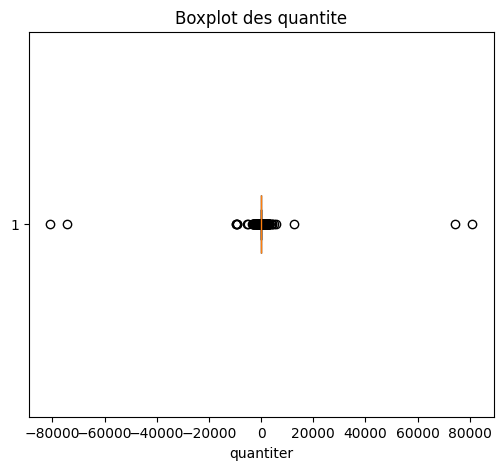

In [7]:
### Analyese des champs quantitative ##
plt.figure(figsize=(6,5))
plt.boxplot(sales['Quantity'], vert=False, patch_artist=True)
plt.xlabel("quantiter")
plt.title("Boxplot des quantite")
plt.show()

In [8]:
### there seems to be something gp ###
sales.loc[sales['Quantity'] > 10000 ]

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
502126,502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.00,13256.0,United Kingdom
540421,540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom


In [9]:
### let's get started with products that have no unit price
sales.loc[ (sales['UnitPrice'] == 0) & (sales['Description'] != 'unknown product')]

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
6391,6391,536941,22734,amazon,20,2010-12-03 12:08:00,0.0,unknown,United Kingdom
6392,6392,536942,22139,amazon,15,2010-12-03 12:08:00,0.0,unknown,United Kingdom
7313,7313,537032,21275,?,-30,2010-12-03 16:50:00,0.0,unknown,United Kingdom
9302,9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany
13217,13217,537425,84968F,check,-20,2010-12-06 15:35:00,0.0,unknown,United Kingdom
...,...,...,...,...,...,...,...,...,...
535336,535336,581213,22576,check,-30,2011-12-07 18:38:00,0.0,unknown,United Kingdom
536908,536908,581226,23090,missing,-338,2011-12-08 09:56:00,0.0,unknown,United Kingdom
538504,538504,581406,46000M,POLYESTER FILLER PAD 45x45cm,240,2011-12-08 13:58:00,0.0,unknown,United Kingdom
538505,538505,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,2011-12-08 13:58:00,0.0,unknown,United Kingdom


In [10]:
sales['Desc'] = sales['Description'].str.replace(r'\s+','0',regex=True)

In [ ]:
sales_cleaned = sales.loc[sales['Desc'].str.contains(r'[^a-zA-Z0-9]',regex=True)]
sales_cleaner = sales_cleaned.loc[sales_cleaned['Description'].str.contains(r'[.,?@]+',regex=True)]
sales_cleaner['Description'].size

7253

In [66]:
np.sort(sales_cleaner['Description'].unique()).size

133

In [65]:
test = sales_cleaner[~sales_cleaner['Description'].str.contains(r'^\?+$', regex=True)]
test['Description'].unique().size

130

In [11]:
## 0 meaning data must be removed
## the ~ is like ! 
## first we get rid of useless data
sales = sales.loc[~sales['Description'].str.contains(r'^\?+$',regex=True)]
sales_copy = sales.copy()

In [29]:
## giving the name same white spaces and removing dots
sales_copy['Description'] = sales_copy['Description'].str.replace(r'\s+',' ',regex=True).str.replace(r'^[*.,!?/]|[*.,!?]|[*.,!?]$','',regex=True).str.strip()

In [42]:
sales_copy['Description'].unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ..., 'mixed up',
       'CREAM HANGING HEART T-LIGHT HOLDER', 'PAPER CRAFT LITTLE BIRDIE'],
      shape=(4167,), dtype=object)

In [31]:
desc = pd.DataFrame(sales_copy['Description'].unique())

In [43]:
sales_copy = sales_copy.loc[~((sales_copy['Description'].str.contains(r'wrongly')) & (sales_copy['Quantity'] < 0 )) ]
sales_copy = sales_copy.loc[~(sales_copy['Description'].str.contains(r'wrongly'))]

In [44]:
sales_copy.loc[sales_copy['Description'].str.contains('wrongly')]

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Desc


In [78]:
sales_copy.loc[sales_copy['Description'].str.contains(r'\bdamage(?:d\b|\b)?'),'Description'] = 'Dameged' 
sales_copy.loc[sales_copy['Description'].str.contains(r'\bcrush(?:ed\b|\b)?'),'Description'] = 'Crushed' 
sales_copy.loc[sales_copy['Description'].str.contains(r'throw'),'Description'] = 'Thrown' 
sales_copy.loc[sales_copy['Description'].str.contains(r'^wet'),'Description'] = 'Wet' 
sales_copy.loc[sales_copy['Description'].str.contains(r'^wrong'),'Description'] = 'Wrong Code' 
sales_copy.loc[sales_copy['Description'].str.contains(r'^sold'),'Description'] = 'Sold' 
sales_copy.loc[sales_copy['Description'].str.contains(r'^reverse'),'Description'] = 'Reverse'
sales_copy.loc[sales_copy['Description'].str.contains(r'^mouldy'),'Description'] = 'Mouldy'
sales_copy.loc[sales_copy['Description'].str.contains(r'mix up'),'Description'] = 'Mixed'
sales_copy.loc[sales_copy['Description'].str.contains(r'^lost'),'Description'] = 'Lost'
sales_copy.loc[sales_copy['Description'].str.contains(r'^incorrect'),'Description'] = 'Incorrect'
sales_copy.loc[sales_copy['Description'].str.contains(r'^dotcom'),'Description'] = 'Dotcom'
sales_copy.loc[sales_copy['Description'].str.contains(r'find'),'Description'] = 'Find'

In [79]:
sales_copy['Description'].sort_values(ascending=False).unique()

array(['website fixed', 'unknown product',
       'to push order througha s stock was', ...,
       '12 DAISY PEGS IN WOOD BOX', '12 COLOURED PARTY BALLOONS',
       '10 COLOUR SPACEBOY PEN'], shape=(4108,), dtype=object)